# Access CESM2 data from RDA and compute climatology average

In [3]:
# Imports
import geocat.comp as gc
import intake
import numpy as np
import pandas as pd
import xarray as xr
# import seaborn as sns
import re
import aiohttp

In [4]:
import fsspec.implementations.http as fshttp
from pelicanfs.core import PelicanFileSystem, PelicanMap, OSDFFileSystem 

In [5]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [6]:
year0  = '1991'
year1  = '2020'
year0_str = str(year0)
year1_str = str(year1)

#Boulder coordinates
boulder_lat = 40.0150 
boulder_lon = (360-105.2705)%360
print(boulder_lat,boulder_lon)

40.015 254.7295


In [12]:
# File paths
# rda_scratch = '/gpfs/csfs1/collections/rda/scratch/harshah'
rda_scratch = '/glade/campaign/collections/rda/scratch/harshah'
#
rda_url        =  'https://data.rda.ucar.edu/'
intake_url     = rda_url + 'harshah/intake_catalogs/osdf/cesm2-lens-aws-osdf/aws-cesm2-le.json'

### Spin up a cluster

In [8]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 1,
    memory = '4GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    resource_spec = 'select=1:ncpus=1:mem=4GB',
    queue = 'casper',
    walltime = '3:00:00',
    log_directory = rda_scratch+'/dask/logs',
    #interface = 'ib0'
    interface = 'ext'
)

In [9]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.97:46679,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [10]:
cluster.scale(2)
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.97:46679,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load CESM2 temperature data and apply geocat-comp's climatology average

In [13]:
osdf_catalog = intake.open_esm_datastore(intake_url)
osdf_catalog

,unique
Unnamed: 0,322
variable,53
long_name,51
component,4
experiment,2
forcing_variant,2
frequency,3
vertical_levels,3
spatial_domain,3
units,20


In [14]:
osdf_catalog.df['path'].head().values

array(['osdf:///ncar/rda/d010092/atm/daily/cesm2LE-historical-cmip6-FLNS.zarr',
       'osdf:///ncar/rda/d010092/atm/daily/cesm2LE-historical-cmip6-FLNSC.zarr',
       'osdf:///ncar/rda/d010092/atm/daily/cesm2LE-historical-cmip6-FLUT.zarr',
       'osdf:///ncar/rda/d010092/atm/daily/cesm2LE-historical-cmip6-FSNS.zarr',
       'osdf:///ncar/rda/d010092/atm/daily/cesm2LE-historical-cmip6-FSNSC.zarr'],
      dtype=object)

In [15]:
osdf_catalog_temp = osdf_catalog.search(variable ='TREFHT', frequency ='daily',forcing_variant='cmip6')
osdf_catalog_temp

,unique
Unnamed: 0,2
variable,1
long_name,1
component,1
experiment,2
forcing_variant,1
frequency,1
vertical_levels,1
spatial_domain,1
units,1


In [16]:
%%time
#dsets = osdf_catalog_temp.to_dataset_dict(storage_options={'anon':True})
dsets = osdf_catalog_temp.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


CPU times: user 681 ms, sys: 121 ms, total: 801 ms
Wall time: 22 s


In [17]:
%%time
dsets.keys()

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.05 μs


dict_keys(['atm.historical.daily.cmip6', 'atm.ssp370.daily.cmip6'])

In [18]:
historical_cmip6 = dsets['atm.historical.daily.cmip6']
historical_cmip6 = historical_cmip6.TREFHT
historical_cmip6

<xarray.DataArray 'TREFHT' (member_id: 50, time: 60225, lat: 192, lon: 288)> Size: 666GB
dask.array<open_dataset-TREFHT, shape=(50, 60225, 192, 288), dtype=float32, chunksize=(1, 730, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Reference height temperature
    units:         K

#### To illustrate how the function works select small subset
- Choose data between year0 and year1
- Choose data from only one member
- Choose data for Boulder

In [19]:
%%time
historical_cmip6_30years = historical_cmip6.isel(member_id=0).sel(lat =boulder_lat,lon=boulder_lon,method='nearest').\
                             sel(time = slice(f'{year0_str}-01-01', f'{year1_str}-12-31'))
historical_cmip6_30years

CPU times: user 50.6 ms, sys: 0 ns, total: 50.6 ms
Wall time: 90.1 ms


<xarray.DataArray 'TREFHT' (time: 8760)> Size: 35kB
dask.array<getitem, shape=(8760,), dtype=float32, chunksize=(730,), chunktype=numpy.ndarray>
Coordinates:
    lat        float64 8B 40.05
    lon        float64 8B 255.0
    member_id  <U12 48B 'r10i1181p1f1'
  * time       (time) object 70kB 1991-01-01 12:00:00 ... 2014-12-31 12:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Reference height temperature
    units:         K

CPU times: user 852 ms, sys: 74.3 ms, total: 926 ms
Wall time: 19.6 s


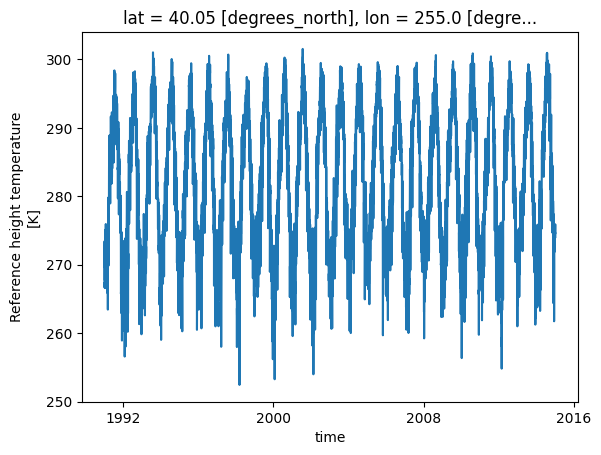

In [25]:
%%time
# Plot raw data
historical_cmip6_30years.plot()

In [20]:
# historical_cmip6_30years.values

array([267.34772, 266.6816 , 272.03006, ..., 275.552  , 275.90695,
       274.0442 ], dtype=float32)

In [21]:
%%time
hist_cmip6_monthly = gc.climatology_average(historical_cmip6_30years,freq='month')
hist_cmip6_monthly

CPU times: user 333 ms, sys: 29.4 ms, total: 362 ms
Wall time: 723 ms


<xarray.DataArray 'TREFHT' (time: 12)> Size: 48B
dask.array<groupby_nanmean, shape=(12,), dtype=float32, chunksize=(12,), chunktype=numpy.ndarray>
Coordinates:
    lat        float64 8B 40.05
    lon        float64 8B 255.0
    member_id  <U12 48B 'r10i1181p1f1'
  * time       (time) object 96B 2002-01-16 12:00:00 ... 2002-12-16 12:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Reference height temperature
    units:         K

CPU times: user 892 ms, sys: 70 ms, total: 962 ms
Wall time: 19.4 s


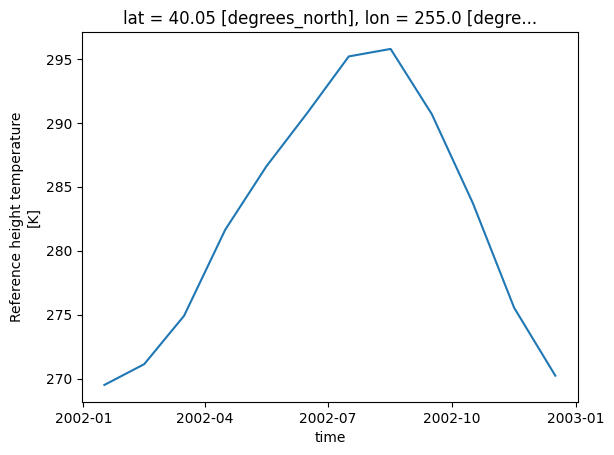

In [23]:
%%time
hist_cmip6_monthly.plot()

<!-- cluster.close() -->